In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint

In [2]:
Sigmin = 0.01
Target = 2

def get_batch(N = 1000):
    xs = np.random.uniform(-3,3, size = (N,))
    times = np.random.uniform(0,1, size = (N,))
    xt = np.column_stack([xs,times])
    return xt

In [3]:
def conditional_field(position, time, target, sigmin):
    return (target - (1-sigmin)*position) / (1-(1-sigmin)*time)

def conditional_sample(target, time, sigmin, noise):
    mean = target*time
    sigma = 1 - (1-sigmin)*time
    return mean + sigma*noise

xt = get_batch(1000)
target = np.full_like(xt[:,0], Target)
fieldx = conditional_field(xt[:,0],xt[:,1], target, Sigmin)

(-3.0, 3.0)

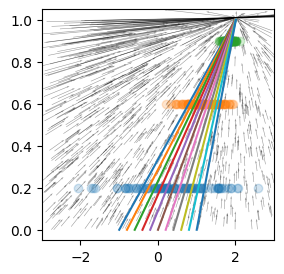

In [8]:
tint = np.linspace(0.0,1.0)
xint = odeint(lambda t,x: conditional_field(x,t,Target,Sigmin), torch.tensor(np.linspace(-1,1,11).reshape(-1,1)), torch.tensor(tint))
xint, tint = np.broadcast_arrays(xint,tint.reshape(-1,1,1))

plt.plot(xint[...,0], tint[...,0])
plt.quiver(xt[:,0],xt[:,1], fieldx,np.ones_like(fieldx), angles = 'xy', scale_units = 'xy', scale = 20, alpha = 0.4)
for time in [0.2,0.6,0.9]:
    samples = conditional_sample(Target, time, Sigmin, torch.randn(100,))
    plt.scatter(samples, np.full_like(samples, time), alpha = 0.2)

plt.gcf().set_size_inches(3,3)
plt.xlim(-3,3)

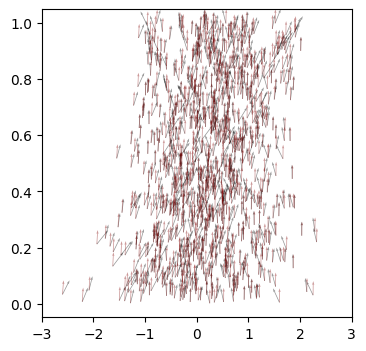

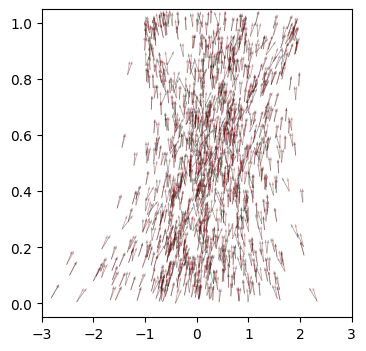

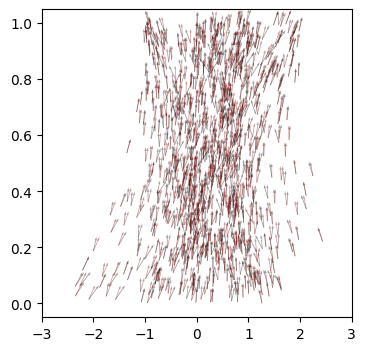

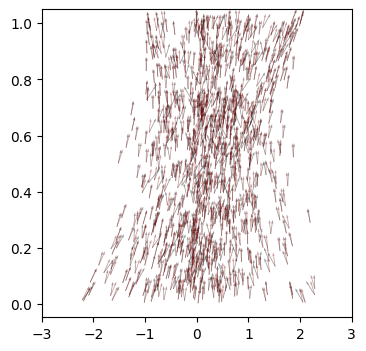

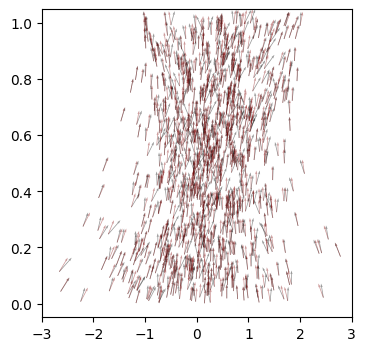

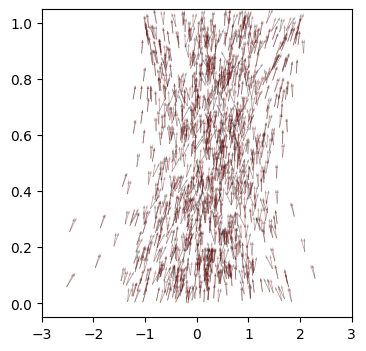

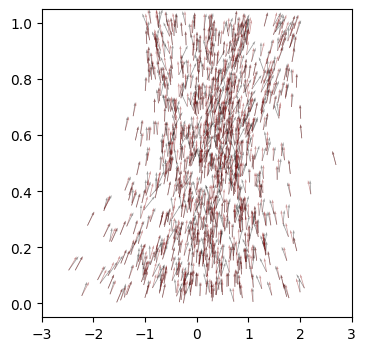

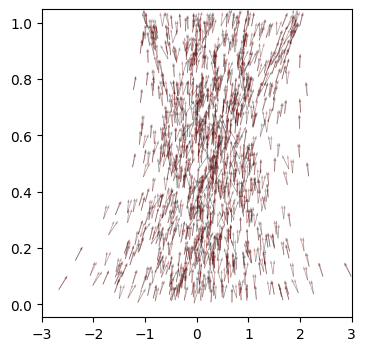

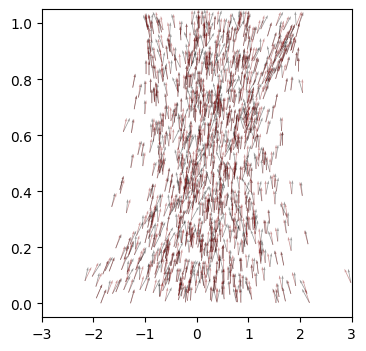

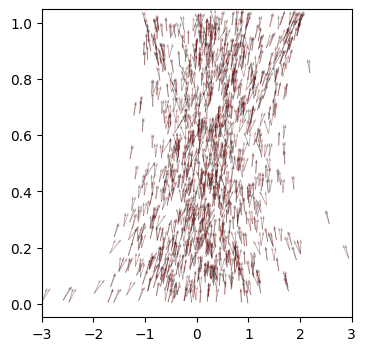

In [12]:
# conditional_field(position, time, target, sigmin)
# unconditional_field(position, time) -> 1
import sklearn.datasets as skld

def sample_data(N = 100):
    # target = torch.FloatTensor(np.random.choice([2,-2], size = batch_size, replace=True))
    target = torch.FloatTensor(skld.make_moons(N)[0][:,0])
    return target


def train():
    model = torch.nn.Sequential(
        torch.nn.Linear(2,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,1)
    )
    opt = torch.optim.Adam(model.parameters(), 1e-3)

    for i in range(10000):
        batch_size = 1000
        target = sample_data(batch_size)
        times = torch.rand(batch_size)
        position = conditional_sample(target, times, Sigmin, torch.randn(batch_size))
        xt = torch.column_stack([position, times])
        mfield = model(torch.FloatTensor(xt))[:,0]
        cond_field = torch.FloatTensor(conditional_field(xt[:,0].numpy(),xt[:,1].numpy(), target.numpy(), Sigmin))
        loss = torch.nn.functional.mse_loss(mfield, cond_field)
        loss.backward()
        opt.step()
        opt.zero_grad()
        if i % 1000 == 0:
            mfield_d = mfield.detach()
            plt.quiver(xt[:,0],xt[:,1], cond_field,np.ones_like(cond_field), angles = 'xy', scale_units = 'xy', scale = 20, alpha = 0.4, color = 'black')
            plt.quiver(xt[:,0],xt[:,1], mfield_d,np.ones_like(mfield_d), angles = 'xy', scale_units = 'xy', scale = 20, alpha = 0.4, color = 'maroon')
            plt.gcf().set_size_inches(4,4)
            plt.xlim(-3,3)
            plt.show()
    return model
trained_model = train()

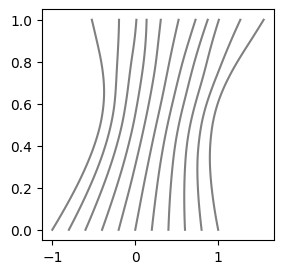

In [15]:
tint = np.linspace(0.0,1.0)
xint = odeint(lambda t,x: trained_model(torch.cat([x,torch.full(x.shape, t.item())],dim=-1).float()).detach(), torch.tensor(np.linspace(-1,1,11).reshape(-1,1)), torch.tensor(tint))
xint, tint = np.broadcast_arrays(xint,tint.reshape(-1,1,1))
plt.plot(xint[...,0], tint[...,0], c = 'grey')
plt.gcf().set_size_inches(3,3)

/var/folders/hn/y10jq2sn3cs3wnqv65l2rc040000gn/T/ipykernel_7731/222347859.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xint = odeint(lambda t,x: trained_model(torch.cat([x,torch.full(x.shape, t.item())],dim=-1).float()).detach(), noise, torch.tensor(tint))


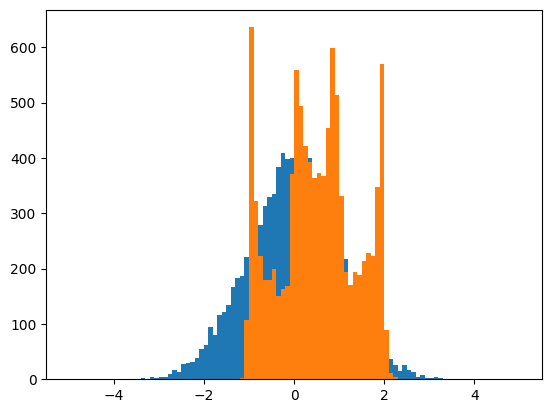

In [16]:
tint = torch.FloatTensor([0.0,1.0])
noise = torch.randn(10000,1)
xint = odeint(lambda t,x: trained_model(torch.cat([x,torch.full(x.shape, t.item())],dim=-1).float()).detach(), noise, torch.tensor(tint))
bins = np.linspace(-5,5,101)
plt.hist(xint[0,::,-1].detach(), bins = bins)
plt.hist(xint[-1,::,-1].detach(), bins = bins);

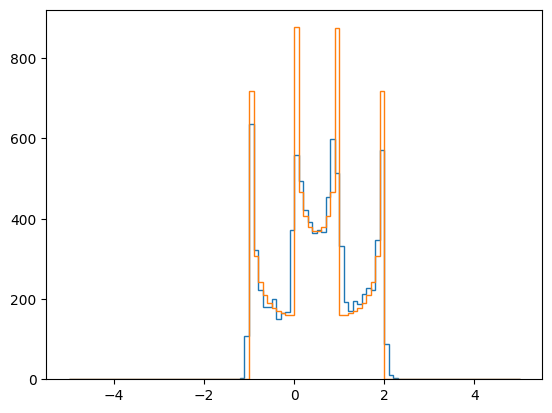

In [17]:
import sklearn.datasets as skld
plt.hist(xint[-1,::,-1].detach(), bins = bins, histtype = 'step')
plt.hist(skld.make_moons(10000)[0][:,0], bins = bins, histtype='step');